# Statistical analysis

---

In [1]:
import os
import glob
import logging
import time

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
from clustergram import Clustergram as CGram

import scipy
from scipy import signal
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression as LR

# Dim. reduction and clasterization

## Preprocessing

#### Raw/norm data frames

In [24]:
pf_df = pd.read_csv('/home/wisstock/bio/scripts/microca/output/F_7_output.csv')

abs_df = pf_df.copy()
abs_df = abs_df.iloc[:,:12]

norm_df = pf_df.copy()
norm_df = norm_df.drop(list(norm_df.columns[9:12]), axis=1)

opti_col = ['sample', 'comp', 'app_group', 'peak_i', 'peak_time', 'rise', 'decay', 'FWHM', 'integral_abs', 'amp_dF']
opti_df = pf_df.copy()
opti_df = opti_df[np.intersect1d(opti_df.columns, opti_col)]
print(opti_df.head())

work_df = opti_df

        FWHM    amp_dF app_group  comp      decay  integral_abs  peak_i  \
0   6.688466  0.229228      ctrl     1  33.645333  16121.706034     200   
1   4.375158  0.199253       BSA     1  14.109333   5428.249887     508   
2   9.280221  0.272256   BSA+C5a     1  10.853333   6497.623084     661   
3  19.375967  1.198913   BSA+C5a     1  32.560000  21308.982278    1019   
4  21.286804  0.218768   BSA+C5a     1  41.242667  18907.216631    1205   

     peak_time       rise sample  
0   217.211474  28.218667    F_7  
1   551.717145   7.597333    F_7  
2   717.883923  14.109333    F_7  
3  1106.692462  33.645333    F_7  
4  1308.699133  32.560000    F_7  


#### Features importance estimation

PCA()


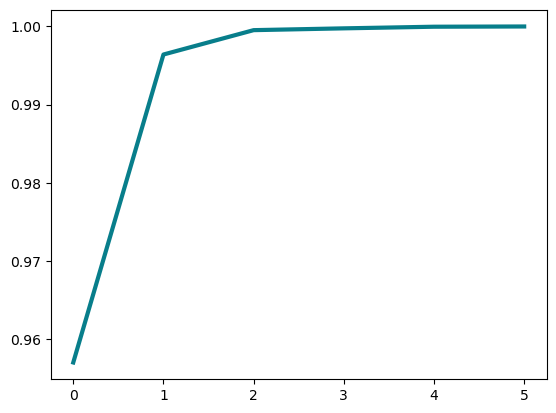

In [3]:
# https://python-bloggers.com/2021/01/3-essential-ways-to-calculate-feature-importance-in-python/

abs_features_vals = abs_df.iloc[:,6:].values

abs_pca = PCA()
abs_features_pca = abs_pca.fit(X=abs_features_vals)

print(abs_features_pca)

plt.plot(abs_features_pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.show()


## PCA

#### PCA calc

In [25]:
def PCA_calc(features_vals, factor_df, n=2):
    tic = time.perf_counter()

    if n == 2:
        ax_list = ['x', 'y']
    elif n == 3:
        ax_list = ['x', 'y', 'z']
    else:
        logging.fatal('Incorrect dimension number!')

    pca = PCA(n_components=n)
    principal_res = pca.fit_transform(features_vals)
    df_principal = pd.DataFrame(data = principal_res,
                                columns = ax_list)
    df_principal = pd.concat([factor_df, df_principal], axis = 1)

    toc = time.perf_counter()
    logging.info(f'PCA calc in {toc - tic:0.4f} seconds')
    return df_principal

n_components = 3
features_vals = work_df[['rise', 'decay', 'FWHM', 'integral_abs', 'amp_dF']].values
factor_df = work_df[['sample', 'comp', 'app_group', 'peak_i', 'peak_time', ]]

pca_df = PCA_calc(features_vals=features_vals, factor_df=factor_df, n=n_components)

#### PCA plot

In [26]:
group_factor = 'app_group'

if n_components == 2:
    fig = px.scatter(pca_df,
                     x='x', y='y',
                     color=group_factor,
                     symbol=group_factor)
    dot_size = 6
elif n_components == 3:
    fig = px.scatter_3d(pca_df,
                        x='x', y='y', z='z',
                        color=group_factor,
                        symbol=group_factor)
    dot_size = 2
else:
    logging.fatal('Incorrect n')

fig.update_traces(marker=dict(size=5))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  legend= {'itemsizing': 'constant'},
                  scene=dict(xaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title=''),
                             yaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title=''), 
                             zaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title='')))
fig.show()

## LDA

#### LDA calc

In [27]:
def LDA_calc(features_vals, factor_df, group_column=None):
    tic = time.perf_counter()

    group_vals = factor_df.loc[:,group_column].values

    lda = LDA()
    lda_fit = lda.fit_transform(X=features_vals, y=group_vals)
    df_lda = pd.DataFrame({'lda1':lda_fit[:,0], 'lda2':lda_fit[:,1]})
    df_lda = pd.concat([factor_df, df_lda], axis = 1)

    toc = time.perf_counter()
    logging.info(f'PCA calc in {toc - tic:0.4f} seconds')
    return df_lda

features_vals = work_df[['rise', 'decay', 'FWHM', 'integral_abs', 'amp_dF']].values
factor_df = work_df[['sample', 'comp', 'app_group', 'peak_i', 'peak_time', ]]
lda_df = LDA_calc(features_vals=features_vals, factor_df=factor_df, group_column='app_group')


print(lda_df.head())

# plotting
# fig = px.box(lda_df, x="app_group", y="lda", color='app_group', points='all')
fig = px.scatter(lda_df, x="lda1", y="lda2", color='app_group')
fig.show()

  sample  comp app_group  peak_i    peak_time      lda1      lda2
0    F_7     1      ctrl     200   217.211474  1.322437  0.942129
1    F_7     1       BSA     508   551.717145  0.439960 -0.392011
2    F_7     1   BSA+C5a     661   717.883923  0.660320 -0.085072
3    F_7     1   BSA+C5a    1019  1106.692462  0.839148  3.092482
4    F_7     1   BSA+C5a    1205  1308.699133  0.741152  1.671788


## Clustergram

In [ ]:
cgram = CGram(range(1, 16), n_init=1000)

cgram.fit(norm_df.iloc[:,6:])

In [ ]:
ax = cgram.plot(figsize=(10, 8))
ax.yaxis.grid(False)